In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
                          #mean   #S.D
])

#converting images to tensors and normalizing.
#why we need to normalize?
#scaling pixel range to centerd around zero. nice
#I think it is done for faster perfermance. nice

trainset = torchvision.datasets.MNIST(root='./data',train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 64, shuffle = True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15119551.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 482408.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4384833.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2991603.14it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



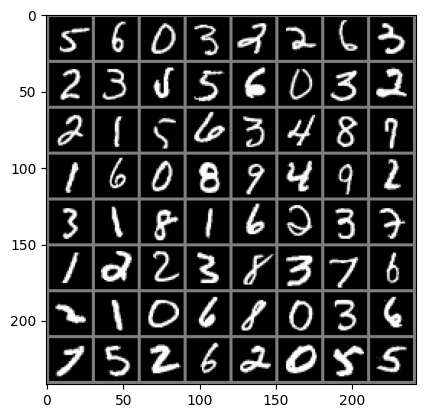

In [4]:
def imshow(img):
  img = img/2 + 0.5 #denormalize the image, (simple math)
  npimg = img.numpy() #can i display image without converting to numpy array?
  plt.imshow(np.transpose(npimg,(1,2,0)), cmap = 'gray')
                          #(C,H,W) to (H,W,C)
  plt.show()

def show_grid(images):
  img_grid = torchvision.utils.make_grid(images,nrow = 8)
  imshow(img_grid)


#getting random training images

trainloader_for_vis = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
dataiter = iter(trainloader_for_vis)
images, labels = next(dataiter)

show_grid(images)

In [ ]:
# import torch
# import torch.nn as nn

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         self.model = nn.Sequential(
#             # 1st layer
#             nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),  # Output: 64 x 14 x 14
#             nn.LeakyReLU(0.2, inplace=True),

#             # 2nd layer
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),  # Output: 128 x 7 x 7
#             nn.BatchNorm2d(128),  # to stabilize training, faster convergence
#             nn.LeakyReLU(0.2, inplace=True),

#             # 3rd layer
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),  # Output: 256 x 3 x 3
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),

#             # 4th layer
#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),  # Output: 512 x 1 x 1
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2, inplace=True),

#             # Flatten and fully connected layers
#             nn.Flatten(),  # 512 feature maps of 1x1, let's flatten it.
#             nn.Linear(512 * 1 * 1, 256),  # Match the flattened size
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         # Print the shape at each step to debug
#         x = self.model(x)
#         return x



In [17]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # 1st layer
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),  # Output = 64 x 14 x 14
            nn.LeakyReLU(0.2, inplace=True),

            # 2nd layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),  # Output =  128 x 7 x 7
            nn.BatchNorm2d(128),  # to stabilize training, faster convergence
            nn.LeakyReLU(0.2, inplace=True),


            # Flatten and fully connected layers
            nn.Flatten(),  # 128 feature maps of 7x7, let's flatten it.
            nn.Linear(128 * 7 * 7,1),# Match the flattened size
            nn.Sigmoid()
        )

    def forward(self, x):
      x = self.model(x)
      return x



In [18]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Input is latent_dim dimensional noise
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 1, 4, 2, 3, bias=False),
            nn.Tanh() # Output pixel values normalized between -1 and 1
        )

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)  # Reshape input to match ConvTranspose2d expected input shape
        x = self.main(x)
        return x

In [19]:
# Using available hardware device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating the generator and discriminator
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# creating binary cross entropy loss instancea
criterion = nn.BCELoss()

# creating optimizers for generator and discriminator
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [20]:
# cell-7
# Containers to store losses for visualization purpose
num_epochs = 20
discriminator_loss = []
generator_loss = []

Epoch [1/20], Step [200/938], d_loss: 0.3835, g_loss: 4.1055, D(x): 0.91, D(G(z)): 0.02
Epoch [1/20], Step [400/938], d_loss: 0.4666, g_loss: 3.4664, D(x): 0.83, D(G(z)): 0.02
Epoch [1/20], Step [600/938], d_loss: 0.6261, g_loss: 3.4737, D(x): 0.84, D(G(z)): 0.14
Epoch [1/20], Step [800/938], d_loss: 0.4804, g_loss: 2.9850, D(x): 0.79, D(G(z)): 0.06
Epoch [2/20], Step [200/938], d_loss: 0.4737, g_loss: 2.8582, D(x): 0.90, D(G(z)): 0.08
Epoch [2/20], Step [400/938], d_loss: 0.5616, g_loss: 2.0431, D(x): 0.96, D(G(z)): 0.12
Epoch [2/20], Step [600/938], d_loss: 0.4637, g_loss: 3.7231, D(x): 0.88, D(G(z)): 0.05
Epoch [2/20], Step [800/938], d_loss: 0.5093, g_loss: 3.2017, D(x): 0.81, D(G(z)): 0.05
Epoch [3/20], Step [200/938], d_loss: 0.5358, g_loss: 2.7411, D(x): 0.90, D(G(z)): 0.14
Epoch [3/20], Step [400/938], d_loss: 0.5853, g_loss: 2.3979, D(x): 0.79, D(G(z)): 0.09
Epoch [3/20], Step [600/938], d_loss: 0.6211, g_loss: 2.4364, D(x): 0.69, D(G(z)): 0.09
Epoch [3/20], Step [800/938], d_

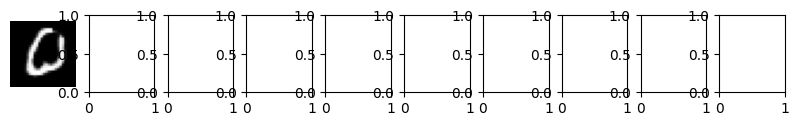

Epoch [11/20], Step [200/938], d_loss: 1.2450, g_loss: 1.0764, D(x): 0.50, D(G(z)): 0.35
Epoch [11/20], Step [400/938], d_loss: 1.2485, g_loss: 1.0033, D(x): 0.74, D(G(z)): 0.51
Epoch [11/20], Step [600/938], d_loss: 1.2362, g_loss: 0.7824, D(x): 0.49, D(G(z)): 0.35
Epoch [11/20], Step [800/938], d_loss: 1.1916, g_loss: 0.8704, D(x): 0.56, D(G(z)): 0.38
Epoch [12/20], Step [200/938], d_loss: 1.0936, g_loss: 0.8960, D(x): 0.50, D(G(z)): 0.27
Epoch [12/20], Step [400/938], d_loss: 1.1495, g_loss: 1.0438, D(x): 0.60, D(G(z)): 0.39
Epoch [12/20], Step [600/938], d_loss: 1.0397, g_loss: 1.1878, D(x): 0.68, D(G(z)): 0.38
Epoch [12/20], Step [800/938], d_loss: 1.1542, g_loss: 0.9170, D(x): 0.50, D(G(z)): 0.30
Epoch [13/20], Step [200/938], d_loss: 1.3154, g_loss: 1.0827, D(x): 0.46, D(G(z)): 0.30
Epoch [13/20], Step [400/938], d_loss: 1.2759, g_loss: 0.8384, D(x): 0.45, D(G(z)): 0.32
Epoch [13/20], Step [600/938], d_loss: 1.1575, g_loss: 1.0602, D(x): 0.53, D(G(z)): 0.31
Epoch [13/20], Step [

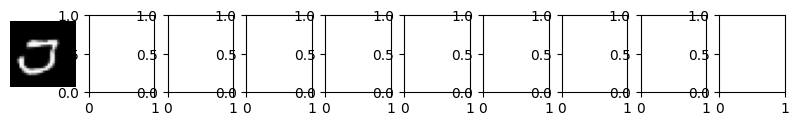

In [22]:
for epoch in range(num_epochs):
    d_epoch_loss = 0
    g_epoch_loss = 0
    for i, (images, _) in enumerate(trainloader):
        batch_size = images.size(0)
        images = images.to(device)

        # Create labels for training discriminator and generator
        real_labels = torch.full((batch_size, 1), 0.9).to(device)  # Smooth real labels to 0.9
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ====================================================================
        # TRAINING DISCRIMINATOR
        # ====================================================================
        # Step1: Infer the discriminator on real images
        real_images_noisy = images + 0.05 * torch.randn_like(images).to(device)  # Add noise to real images
        outputs = discriminator(real_images_noisy)  # Pass real images to discriminator

        # Step2: Calculate the loss with real labels
        d_real_data_loss = criterion(outputs, real_labels)  # Use appropriate loss function (e.g., BCEWithLogitsLoss)
        real_score = outputs.mean().item()  # Average the discriminator scores

        # Step3: Generate random latent vectors from normal distribution
        z = torch.randn(batch_size, latent_dim).to(device)  # Sample noise with correct dimension

        # Step4: Generate fake images by passing latent vector to generator
        fake_images = generator(z)

        # Step5: Infer the discriminator on fake images
        fake_images_noisy = fake_images + 0.05 * torch.randn_like(fake_images).to(device)  # Add noise to fake images
        outputs = discriminator(fake_images_noisy.detach())  # Detach to avoid backprop through generator during discriminator training

        # Step6: Calculate the loss with fake labels
        d_fake_data_loss = criterion(outputs, fake_labels)
        fake_score = outputs.mean().item()

        # Step7: Calculate the total loss (combine real and fake loss)
        d_loss = (d_real_data_loss + d_fake_data_loss)

        d_epoch_loss += d_loss.item()

        # Step8: Update the weights of the discriminator
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()


        # ====================================================================
        # TRAINING GENERATOR
        # ====================================================================

        # Step1: Generate random latent vectors from normal distribution (same as before)
        z = torch.randn(batch_size, latent_dim).to(device)

        # Step2: Generate fake images by passing latent vector to generator
        fake_images = generator(z)

        # Step3: Infer the discriminator on fake images (but use real labels to trick the generator)
        outputs = discriminator(fake_images)  # Pass fake images to discriminator

        # Step4: Calculate the loss with real labels (generator wants to fool the discriminator)
        g_loss = criterion(outputs, real_labels)  # Use appropriate loss function (e.g., BCEWithLogitsLoss)

        g_epoch_loss += g_loss.item()

        # Step5: Update the weights of the generator
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score:.2f}, D(G(z)): {fake_score:.2f}')

    generator_loss.append(g_epoch_loss / i)
    discriminator_loss.append(d_epoch_loss / i)

    # Visualize the intermediate results (same as before)
    if (epoch+1) % 10 == 0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        fake_images = fake_images.detach().cpu().numpy()

        fig, ax = plt.subplots(1, 10, figsize=(10, 1))
        for i in range(10):
            ax[i].imshow(fake_images[i, 0], cmap='gray')
            ax[i].axis('off')
            plt.show()


In [23]:

#saving the model
torch.save(generator, 'generator.pt')
torch.save(discriminator, 'discriminator.pt')

In [24]:
import matplotlib.pyplot as plt

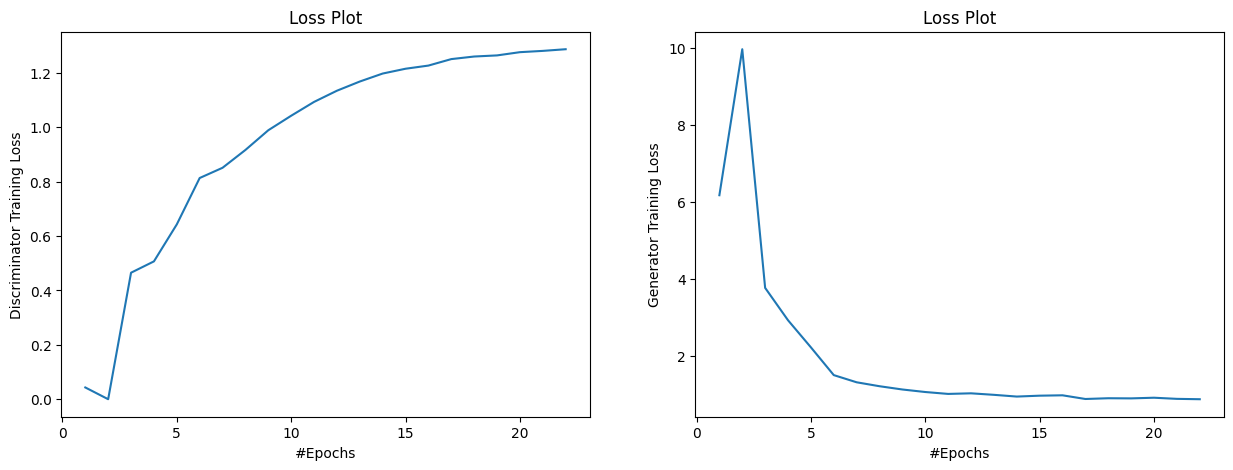

In [25]:

plt.figure(figsize=(15, 5))

# Subplot for discriminator and generator loss
plt.subplot(1, 2, 1)
plt.title("Loss Plot")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, discriminator_loss)
plt.xlabel("#Epochs")
plt.ylabel("Discriminator Training Loss")

plt.subplot(1, 2, 2)
plt.title("Loss Plot")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, generator_loss)
plt.xlabel("#Epochs")
plt.ylabel("Generator Training Loss")
plt.show()

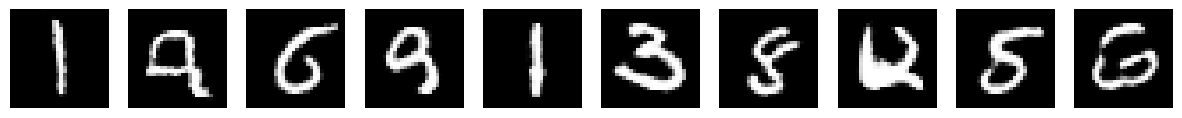

In [26]:
# Load the model (assuming you have saved the generator)
generator = torch.load("generator.pt")  # Replace with your model path

# Set the generator to evaluation mode (optional but recommended)
generator.eval()  # Disables dropout and batchnorm layers (if used)

# Generate latent vectors
num_samples = 10
input_noise = torch.randn(num_samples, latent_dim).to(device)  # Sample noise with correct dimension

# Generate image using latent vectors
generated_samples = generator(input_noise)

# Convert to numpy array for visualization
generated_samples_np = generated_samples.detach().cpu().numpy()

# Visualize the generated samples
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
  axes[i].imshow(generated_samples_np[i, 0], cmap='gray')
  axes[i].axis('off')
plt.show()
